# **S14 Group 14 - Hotel Booking Demand**
Group Members
* Annika Capada
* Lauren Garcia
* Angel Lou Yabut

# Research Question

### Is there any pattern that is common with the booking date of hotels in Portugal?

This question arose from exploring the lead time of the bookings and how it varied through different months. The dataset does not contain the initial dates of booking so in the next phase, we would like to create that variable and explore if the booking date shows any pattern.

This research question was chosen so that if any pattern is identified in the booking date, then hotel guests can get a better idea of when to book their hotel stays and secure a hotel room. This question would also help hotel workers understand when more guests would arrive. This would allow them to prepare in advance and provide quality customer experience especially during busy times. Additionally, enforce strategies to maximize efficiency and profit depending on the month. 

To answer this question, we plan on using the time-series data modelling technique. Through this technique, we would like to observe how the booking date varies through months and years.

# Data Modeling
Perform the necessary steps in answering the research question that you have identified. In this section of the notebook, please take note of the following:
* If needed, perform preprocessing techniques to transform the data to the appropriate representation before performing modelling to answer the research question. This may include binning, log transformations, conversion to one-hot encoding, normalization, standardization, interpolation, truncation, and feature engineering.
* Use data modelling techniques that are discussed in class. The technique should be appropriate to answer the research question.

In [6]:
! pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from pmdarima.arima import auto_arima

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In this notebook, the dataset we will be using is the cleaned up data done in Phase 1. This data has already handled missing values and NaN values.

In [8]:
#reading the cleaned up data from Phase 1
hbd_df = pd.read_csv("hbd_clean.csv")

With the cleaned up data, we will only be looking at the bookings that have not been cancelled and where the guests were able to arrive at the hotel for their booking.

In [9]:
confirmed_bookings = hbd_df[hbd_df["is_canceled"] == 0]

## Creating booking date variable

Since we will be looking at the booking date, we need to first create the column itself as the original dataset did not have it in the first place. To do this, we look at the following variables:

- **`lead_time`**: number of days that elapsed between the entering date of the booking into the PMS and the arrival date
- **`arrival_date_year`**: year of arrival date
- **`arrival_date_month`**: month of arrival date
- **`arrival_date_day_of_month`**: day of arrival date



The first step we do is combine the **`arrival_date_year`**, **`arrival_date_month`**, and **`arrival_date_day_of_month`** into  one datetime column. This column will now be known as **`arrival_date`**

In [10]:
#Combining different variables to create datetime of arrival date
confirmed_bookings['arrival_date'] = confirmed_bookings[["arrival_date_year","arrival_date_month","arrival_date_day_of_month"]].apply(lambda x: '/'.join(x.dropna().astype(str)),axis=1)
confirmed_bookings['arrival_date'] = pd.to_datetime(confirmed_bookings['arrival_date'], format='%Y/%B/%d', errors='coerce')
confirmed_bookings['arrival_date']

<ipython-input-10-4fa39647d7a5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  confirmed_bookings['arrival_date'] = confirmed_bookings[["arrival_date_year","arrival_date_month","arrival_date_day_of_month"]].apply(lambda x: '/'.join(x.dropna().astype(str)),axis=1)
<ipython-input-10-4fa39647d7a5>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  confirmed_bookings['arrival_date'] = pd.to_datetime(confirmed_bookings['arrival_date'], format='%Y/%B/%d', errors='coerce')


0       2015-07-01
1       2015-07-01
2       2015-07-01
3       2015-07-01
4       2015-07-01
           ...    
86935   2017-08-30
86936   2017-08-31
86937   2017-08-31
86938   2017-08-31
86939   2017-08-29
Name: arrival_date, Length: 62953, dtype: datetime64[ns]

After getting the actual date of booking, we will use the lead time and subract it from the arrival date to get a datetime variable of the booking date. This data will be stored in a new variable called **`booking_date`**.

In [11]:
#Getting booking date using the arrival date and lead time
confirmed_bookings["booking_date"]=confirmed_bookings["arrival_date"]-pd.to_timedelta(confirmed_bookings["lead_time"], unit='D')
confirmed_bookings["booking_date"]

<ipython-input-11-73cb7e71c1dc>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  confirmed_bookings["booking_date"]=confirmed_bookings["arrival_date"]-pd.to_timedelta(confirmed_bookings["lead_time"], unit='D')


0       2014-07-24
1       2013-06-24
2       2015-06-24
3       2015-06-18
4       2015-06-17
           ...    
86935   2017-08-07
86936   2017-05-21
86937   2017-07-28
86938   2017-05-14
86939   2017-02-05
Name: booking_date, Length: 62953, dtype: datetime64[ns]

## Creating the Date Range

Using the earliest and latest booking date in the dataset, we can generate the daily range and store it into a new dataframe called **`bookings_perdate`**.

In [12]:
bookings_perdate = pd.DataFrame(confirmed_bookings['booking_date'].value_counts())
bookings_perdate.columns = ['booking_count']
bookings_perdate

,booking_count
2015-10-14,281
2016-02-03,252
2016-01-18,246
2016-01-14,229
2016-01-06,224
...,...
2014-10-13,1
2014-09-14,1
2014-04-18,1
2014-10-11,1


Here we reformat the dataframe so that the booking_date is a column and the index is reset.

In [13]:
bookings_perdate = pd.DataFrame(confirmed_bookings['booking_date'].value_counts())
bookings_perdate.columns = ['booking_count']
bookings_perdate.reset_index(inplace = True)
bookings_perdate.rename(columns = {'index':'booking_date'}, inplace = True)
bookings_perdate

,booking_date,booking_count
0,2015-10-14,281
1,2016-02-03,252
2,2016-01-18,246
3,2016-01-14,229
4,2016-01-06,224
...,...,...
965,2014-10-13,1
966,2014-09-14,1
967,2014-04-18,1
968,2014-10-11,1


With `value_counts()`, we can easily count per date occurrence in the series.

Currently, the table above is not set in ascending order. We can generate a date range from the earliest date to the last date in the data using `pd.date_range()`.


In [14]:
bookings_perdate.booking_date.min()

Timestamp('2013-06-24 00:00:00')

In [15]:
bookings_perdate.booking_date.max()

Timestamp('2017-08-31 00:00:00')

In [16]:
booking_date_range = pd.date_range(start=bookings_perdate.booking_date.min(), 
                           end=bookings_perdate.booking_date.max(),
                           freq='D'
                          )
booking_date_range

DatetimeIndex(['2013-06-24', '2013-06-25', '2013-06-26', '2013-06-27',
               '2013-06-28', '2013-06-29', '2013-06-30', '2013-07-01',
               '2013-07-02', '2013-07-03',
               ...
               '2017-08-22', '2017-08-23', '2017-08-24', '2017-08-25',
               '2017-08-26', '2017-08-27', '2017-08-28', '2017-08-29',
               '2017-08-30', '2017-08-31'],
              dtype='datetime64[ns]', length=1530, freq='D')

As we can see from the date range, the earliest date in the dataset goes back to a date in 2013 while the latest date goes up to 2017. Let's plot these dates and see how the number of bookings vary through the years.

Text(0, 0.5, 'Number of bookings')

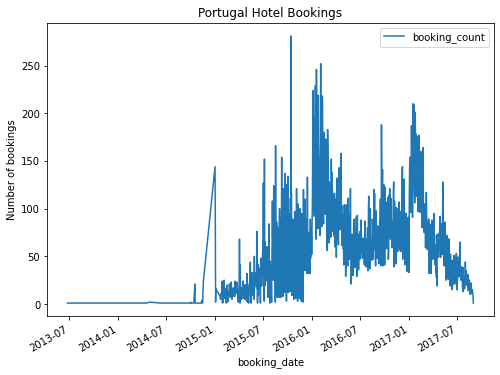

In [17]:
ax = bookings_perdate.plot(x = 'booking_date', figsize=(8, 6))
ax.set_title('Portugal Hotel Bookings')
ax.set_ylabel('Number of bookings')

The plot table seems to have more bookings from 2015 to 2017. Let's view the data range of the arrival dates to see if there's any connection to this.

In [18]:
arrival_date_range = pd.date_range(start=confirmed_bookings.arrival_date.min(), 
                           end=confirmed_bookings.arrival_date.max(),
                           freq='D'
                          )
arrival_date_range

DatetimeIndex(['2015-07-01', '2015-07-02', '2015-07-03', '2015-07-04',
               '2015-07-05', '2015-07-06', '2015-07-07', '2015-07-08',
               '2015-07-09', '2015-07-10',
               ...
               '2017-08-22', '2017-08-23', '2017-08-24', '2017-08-25',
               '2017-08-26', '2017-08-27', '2017-08-28', '2017-08-29',
               '2017-08-30', '2017-08-31'],
              dtype='datetime64[ns]', length=793, freq='D')

In the plot table, we can see that the number of bookings were very few to none from 2013 to 2014. Considering that the cleaned up dataset contained the arrival dates of guests between only 2015 and 2017, this plot table shows that there are very few people who book their hotel rooms as much as 2 years in advance.

We also notice that there's a spike around the beginning of 2015 and the number of bookings is at its highest in 2016. This could mean that more people book at a date that's closer to their arrival date which could be within a year.

# Statistical Inferencing
Perform hypothesis testing to support your answer to the research question. In this section of the notebook, please take note of the following:
* Use statistical inference methods discussed in class.
* Properly state the hypotheses.
* Show necessary pre-processing steps before computing for the p-value.
* Explicitly mention important values such as the resulting p-value and the significance level.

Note that there might be a need to check and prove if the data is from a normal distribution to perform some statistical inference techniques.

## Hypotheses
To recap, our reserach question is:
"Is there any pattern that is common with the booking date of resort and city hotels?"

To answer this question, we will be looking at the stationarity of the time series to see if there is a trend.

**Null**: There is a unit root in the in the booking dates. The time series of booking dates is not stationary.

**Alternative**: There is no unit root in the booking dates.The time series of the booking dates is stationary.

## Daily Moving Average

Here, we will compute for the daily moving aggregate within a window of 28 days. This is so that we can take into account information from past dates and allow the time series to be smoothened, making trend more visible.

In [23]:
daily_agg = bookings_perdate.groupby(pd.Grouper(key='booking_date', freq='D'))['booking_count'].mean().reset_index()
daily_agg['28D_MA'] = daily_agg['booking_count'].rolling(window=28).mean()
daily_agg['28D_STD'] = daily_agg['booking_count'].rolling(window=28).std()

In [24]:
daily_agg

,booking_date,booking_count,28D_MA,28D_STD
0,2013-06-24,1.0,NaN,NaN
1,2013-06-25,NaN,NaN,NaN
2,2013-06-26,NaN,NaN,NaN
3,2013-06-27,NaN,NaN,NaN
4,2013-06-28,NaN,NaN,NaN
...,...,...,...,...
1525,2017-08-27,15.0,20.714286,7.792956
1526,2017-08-28,12.0,20.321429,7.949161
1527,2017-08-29,12.0,19.178571,6.605573
1528,2017-08-30,8.0,18.571429,6.828202


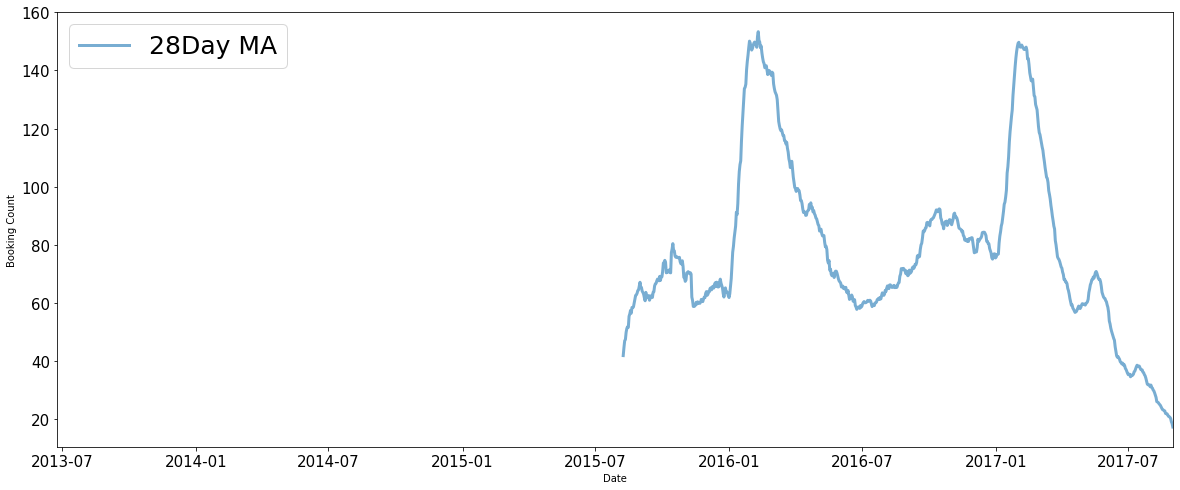

In [27]:
# Smoothness
plt.figure(figsize=(20,8))

#Plotting the 28 Day MA
plt.plot(daily_agg['booking_date'], daily_agg['28D_MA'], label='28Day MA', alpha=0.6, lw=3)

plt.legend(fontsize=25)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlim([pd.to_datetime('2013-06-24'), pd.to_datetime('2017-08-31')])
plt.xlabel('Date')
plt.ylabel('Booking Count');

Based on the graph, we see that there's a gap between 2013 and about mid-year of 2015. This can mean that no significant data that presents as a trend in that time frame. From past July 2015 to July 2017, we see that a trend is present.


We notice that as the date approaches the start of a new year, the booking count slowly increases as well. The number of bookings tend to spike up at the start of a year but quickly decreases afterwards when approaching the months of spring (March, April, May) and summmer (June, July, August). 

This can mean that many people book during the earlier months of the year to prepare for vacation in the spring or summer. This inference is based on the information gathered from Phase 1 where we discovered that the most frequent months for arrival are August and July. 

## Major Components of Observed Time Series

In [ ]:
bookings_perdate

,booking_date,booking_count
0,2015-10-14,281
1,2016-02-03,252
2,2016-01-18,246
3,2016-01-14,229
4,2016-01-06,224
...,...,...
965,2014-10-13,1
966,2014-09-14,1
967,2014-04-18,1
968,2014-10-11,1


In [ ]:
print(bookings_perdate[bookings_perdate.booking_count == bookings_perdate.booking_count.max()])

  booking_date  booking_count
0   2015-10-14            281


In [ ]:
bookings_perdate

,booking_date,booking_count
0,2015-10-14,281
1,2016-02-03,252
2,2016-01-18,246
3,2016-01-14,229
4,2016-01-06,224
...,...,...
965,2014-10-13,1
966,2014-09-14,1
967,2014-04-18,1
968,2014-10-11,1


In [ ]:
decompose_sample = daily_agg.copy()

decompose_sample = decompose_sample['28D_MA'].reset_index()

decompose_sample
 
decompose_sample = decompose_sample.set_index(pd.to_datetime(daily_agg['booking_date'])).dropna()

decompose_sample.sort_index(inplace=True)

decompose_sample.drop('index', axis = 1)



,28D_MA
booking_date,
2015-08-09,41.928571
2015-08-10,44.678571
2015-08-11,47.000000
2015-08-12,47.464286
2015-08-13,49.964286
...,...
2017-08-27,20.714286
2017-08-28,20.321429
2017-08-29,19.178571


In [ ]:
#Get important components of time series
decompose_sample = bookings_perdate.copy()

decompose_sample = decompose_sample.groupby(pd.Grouper(key='booking_date', freq='MS'))['booking_count'].sum().reset_index()

decompose_sample = decompose_sample.set_index(pd.to_datetime(decompose_sample['booking_date'])).dropna()

decompose_sample.sort_index(inplace=True)

In [ ]:
decompose_sample.head(10)

,booking_date,booking_count
booking_date,,
2013-06-01,2013-06-01,1
2013-07-01,2013-07-01,0
2013-08-01,2013-08-01,0
2013-09-01,2013-09-01,0
2013-10-01,2013-10-01,0
2013-11-01,2013-11-01,0
2013-12-01,2013-12-01,0
2014-01-01,2014-01-01,0
2014-02-01,2014-02-01,0


In [ ]:
decompose_sample['Year'] = decompose_sample['booking_date'].dt.year
decompose_sample['Month'] = decompose_sample['booking_date'].dt.month

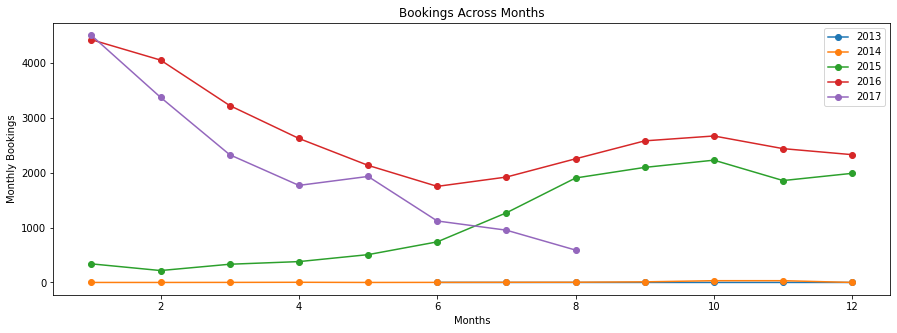

In [ ]:
plt.figure(figsize=(15, 5))
for each in decompose_sample['Year'].unique():
    plt.plot(decompose_sample[decompose_sample['Year'] == each]['Month'],
             decompose_sample[decompose_sample['Year'] == each]['booking_count'], marker='o', label=each)
    
    plt.legend(loc='best')
    plt.xlabel('Months')
    plt.ylabel('Monthly Bookings')
    plt.title('Bookings Across Months')

Based in the graph above, we can see that the number of bookings for 2013 and 2014 are low. The same can also be noticed on the number of bookings at the start of the year in 2015, especially in comparison to 2016 and 2017. This implies that the number of people who book early (from one to even two years) are quite low and people usually book within the year itself.


On the other hand, we see that in 2016 and 2017, the number of bookings are both at its highest at the start of the year (January). This could be because booking at this time of year is cheaper for tourists.

In [ ]:
decomp_result = seasonal_decompose(decompose_sample['booking_date'].asfreq('MS'), model='additive')

Text(0.5, 1.0, 'Residuals')

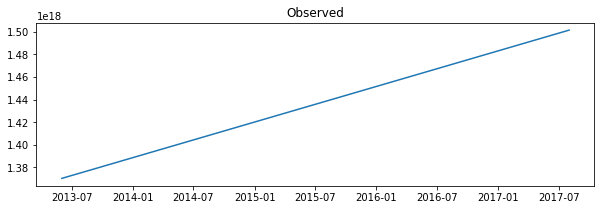

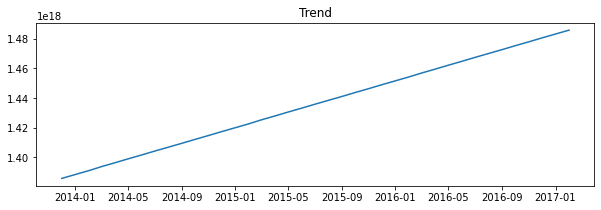

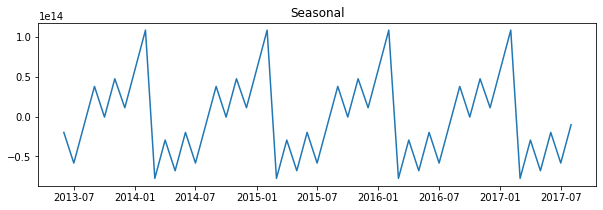

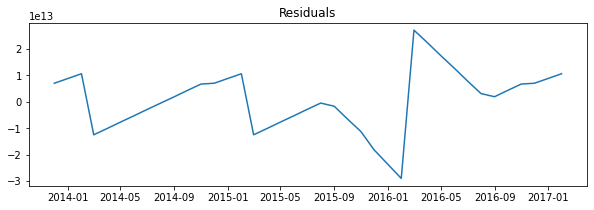

In [ ]:
plt.figure(figsize=(10,3))
plt.plot(decomp_result.observed)
plt.title("Observed")
plt.figure(figsize=(10,3))
plt.plot(decomp_result.trend)
plt.title("Trend")
plt.figure(figsize=(10,3))
plt.plot(decomp_result.seasonal)
plt.title("Seasonal")
plt.figure(figsize=(10,3))
plt.plot(decomp_result.resid)
plt.title("Residuals")

Based on the graphs for observed and trend, there is a linear upward trend which implies that the number of bookings increases throughout time.

As for seasonality, it can be observed that there are periodic fluctuations wherein on the month of July the number of bookings start to increase and peaks during the January. This then decreases afterwards from February until June. Based on this, we can predict that a high number of bookings are to be expected in the last few quarters of the month lasting until January whereas, low bookings are to be expected afterwards. Hence, it is recommended to book our hotel resevation as early as possible during the first quarters in order to ensure ones slot for the hotel.

As for the residual graph, it is taken by getting the difference between the observed value and the predicted value. It is used to validate the previous models and because there is no clear pattern for the residual graph, we can conclude the validity of our models.

## Monthly Expectation

In evaluating the seasonality index that was computed, we can observe  the number of booking is affected depending on the month. Wherein, the bar graph depicts whether a certain month has a positive or negative effect on the number of bookings made.

In [ ]:
seasonality_value = decomp_result.seasonal.reset_index()

In [ ]:
seasonality_value

,booking_date,seasonal
0,2013-06-01,-1.987500e+13
1,2013-07-01,-5.827500e+13
2,2013-08-01,-1.027500e+13
3,2013-09-01,3.772500e+13
4,2013-10-01,-6.750000e+11
5,2013-11-01,4.732500e+13
6,2013-12-01,1.102500e+13
7,2014-01-01,5.962500e+13
8,2014-02-01,1.082250e+14
9,2014-03-01,-7.747500e+13


In [ ]:
seasonality_value['Month'] = seasonality_value['booking_date'].dt.month
seasonality_value = seasonality_value[['seasonal', 'Month']].drop_duplicates()

In [ ]:
seasonality_value

,seasonal,Month
0,-1.987500e+13,6
1,-5.827500e+13,7
2,-1.027500e+13,8
3,3.772500e+13,9
4,-6.750000e+11,10
5,4.732500e+13,11
6,1.102500e+13,12
7,5.962500e+13,1
8,1.082250e+14,2
9,-7.747500e+13,3


<BarContainer object of 7 artists>

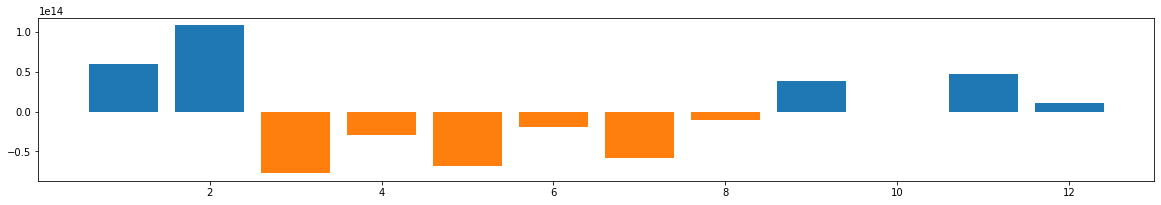

In [ ]:
plt.figure(figsize=(20,3))

plt.bar(seasonality_value[seasonality_value['seasonal'] > 0]['Month'],
        seasonality_value[seasonality_value['seasonal'] > 0]['seasonal'])

plt.bar(seasonality_value[seasonality_value['seasonal'] <= 0]['Month'],
        seasonality_value[seasonality_value['seasonal'] <= 0]['seasonal'])

The bar graph shows that the months of January, February, September, November and December have a positive effect on the number of bookings, with February being the highest. Wherein, there are more bookings being made in average from autumn until winter which are known to be cold months. On the other hand, during the spring (March, April and May) and the summer (June, July and August), there is a negative effect where there are less bookings being made, with its lowest on March. In which, these months are within peak seasons where tourists normally spend their vacation. This shows that tourists normally book their stay during the beginning or end of the year to arrive at the hotel during the spring or summer.

## Augmented Dickey-Fuller Test


To formally test for stationarity, we use the Augmented Dickey-Fuller Test. For the test, we will use the Average Moving results from earlier.

In [ ]:
result = adfuller(daily_agg['booking_count'].dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.087166
p-value: 0.249706
Critical Values:
	1%: -3.437
	5%: -2.865
	10%: -2.568


In the test results, we see that the p-value is greater than 0.05. This means that we cannot reject the null hypothesis. Therefore, the booking date time series **is not a stationary time series**. This means that the time series does have a time-dependent structure.

# Insights and Conclusions
Clearly state your insights and conclusions from the data to answer the research question. Make sure that the conclusion is backed up with statistical evidence using hypothesis testing.

The Augmented Dickey-Fuller test supports our findings from earlier where we saw an upward trend and seasonality.

With regards to the research question, there is a pattern observed in the booking dates.

January and February are observed to be the most popular months for booking. January is observed to have the highest booking count in the Moving Average and decomposed results. For seasonality, it also has a high positive seasonality value but February is notably higher. The number of bookings also slowly increases when approaching January.

A decrease in bookings is observed betwen spring and summer months. This is observed in all graphs presented from the Moving Average, decomposed results, and seasonality values.

Based on these results, it can be inferred that people who want to book a hotel in Portugal are likely to book within the range of the last few quarters of the year to the start of the next year. This may be because of a cheaper rate during those months. 